# Sleep Health Predictor 

### Notebook on Data Cleaning, Preparation and Modeling 


### Goal: 
Predict **`Quality of Sleep`** based on an individual's `Gender`, `Age`, `Occupation`, `Sleep Duration`, `Stress Level`, `Heart Rate`, etc.



### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

### Read the data
The data has been downloaded from Kaggle [*Sleep Health and Lifestyle Dataset*](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset)

To download this data into your local machine, run the script [kaggle-data-import](https://github.com/eadka/sleep-health-predictor/blob/main/data/kaggle-data-import.ipynb) 

In [3]:
df = pd.read_csv('../data/sleep_health_lifestyle.csv')

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


### Data Preparation and Feature Engineering
Lets prepare the data for further evaluation

##### Step 1: Make all the column names small letters and replaces spaces with '_'

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['person_id', 'gender', 'age', 'occupation', 'sleep_duration',
       'quality_of_sleep', 'physical_activity_level', 'stress_level',
       'bmi_category', 'blood_pressure', 'heart_rate', 'daily_steps',
       'sleep_disorder'],
      dtype='object')

##### Step 2: Lets look at the data to find missing values and other metrics

In [6]:
df.describe()

,person_id,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


##### Some observations:
- **Age**: The age group of individuals in the dataset is between 27-59 years.
- **Sleep Duration**: Range is between 5.8-8.5 hours.
- **Quality of sleep**: This is a subjective rating of the quality of sleep, ranging from 1 to 10. Range: 4-9.
- **Physical Activity Level**: The number of minutes the person engages in physical activity daily. Range: 30-90 mins (Everyone exercises!)
- **Stress Level**: A subjective rating of the stress level experienced by the person, ranging from 1 to 10. Range: 3-8.
- **Heart Rate**: The resting heart rate of the person in beats per minute. Range: 65-86 bpm.
- **Daily Steps**: The number of steps the person takes per day. Range: 3000-10000

Let's clean the missing values

In [7]:
df.isnull().sum()

person_id                    0
gender                       0
age                          0
occupation                   0
sleep_duration               0
quality_of_sleep             0
physical_activity_level      0
stress_level                 0
bmi_category                 0
blood_pressure               0
heart_rate                   0
daily_steps                  0
sleep_disorder             219
dtype: int64

In [8]:
df['sleep_disorder'] = df['sleep_disorder'].fillna('None')

In [9]:
df.isnull().sum()

person_id                  0
gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
blood_pressure             0
heart_rate                 0
daily_steps                0
sleep_disorder             0
dtype: int64

##### Step 3: Feature Engineering on the numeric columns from the categorical ones

In [10]:
df.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
quality_of_sleep             int64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure              object
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
dtype: object

Let's separate the numeric and categorical columns

In [11]:
numerical = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')]
numerical

Index(['person_id', 'age', 'sleep_duration', 'quality_of_sleep',
       'physical_activity_level', 'stress_level', 'heart_rate', 'daily_steps'],
      dtype='object')

In [12]:
categorical = df.columns[(df.dtypes == 'object')]
categorical

Index(['gender', 'occupation', 'bmi_category', 'blood_pressure',
       'sleep_disorder'],
      dtype='object')

Lets understand the distribution of labels in the **categorical columns**

In [13]:
for c in categorical:
    print(df[c].value_counts())
    print()

gender
Male      189
Female    185
Name: count, dtype: int64

occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Scientist                4
Software Engineer        4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

bmi_category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

blood_pressure
130/85    99
140/95    65
125/80    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
128/85     3
132/87     3
117/76     2
130/86     2
126/83     2
119/77     2
135/88     2
128/84     2
131/86     2
139/91     2
115/78     2
129/84     2
142/92     2
118/75     2
118/76     1
122/80     1
121/79     1
Name: count, dtype: int64

sleep_disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64



From the above categorical variables, the `blood_pressure` would be better used if it were a numeric variable. Lets separate the text into two values - the higher as `systolic` and the lower as `diastolic` and convert them into integers.

In [14]:
bp_split = df['blood_pressure'].str.split('/', expand=True)

In [15]:
df['systolic'] = bp_split[0].astype(int)
df['diastolic'] = bp_split[1].astype(int)

Lets now get rid of the `blood_pressure` column from the dataset and rearrange our **numerical** and **categorical** variables

In [16]:
del df['blood_pressure']

Let's also delete the `person_id` column because it's not a useful feature

In [17]:
del df['person_id']

We can also see that the `bmi_category` has redundant tags: *Normal* and *Normal Weight*.
Lets merge these as *Normal*

In [18]:
df.loc[df['bmi_category'] == 'Normal Weight', 'bmi_category'] = 'Normal'

In [19]:
df['bmi_category'].value_counts()

bmi_category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

In [20]:
df.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


Let's remove `quality_of_sleep` and `person_id`from the numeric columns because that is our *target variable*

In [21]:
numerical = numerical.difference(['quality_of_sleep', 'person_id'])
numerical

Index(['age', 'daily_steps', 'heart_rate', 'physical_activity_level',
       'sleep_duration', 'stress_level'],
      dtype='object')

ALso let's remove `blood_pressure` from the categorical variable

In [22]:
categorical = categorical.difference(['blood_pressure'])
categorical

Index(['bmi_category', 'gender', 'occupation', 'sleep_disorder'], dtype='object')

### Exploratory Data Analysis

Lets look at the distribution of all the features by plotting them

First, we'll look at the numeric columns

In [23]:
df_num = df[numerical]

Let's plot them all

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'daily_steps'}>],
       [<Axes: title={'center': 'heart_rate'}>,
        <Axes: title={'center': 'physical_activity_level'}>],
       [<Axes: title={'center': 'sleep_duration'}>,
        <Axes: title={'center': 'stress_level'}>]], dtype=object)

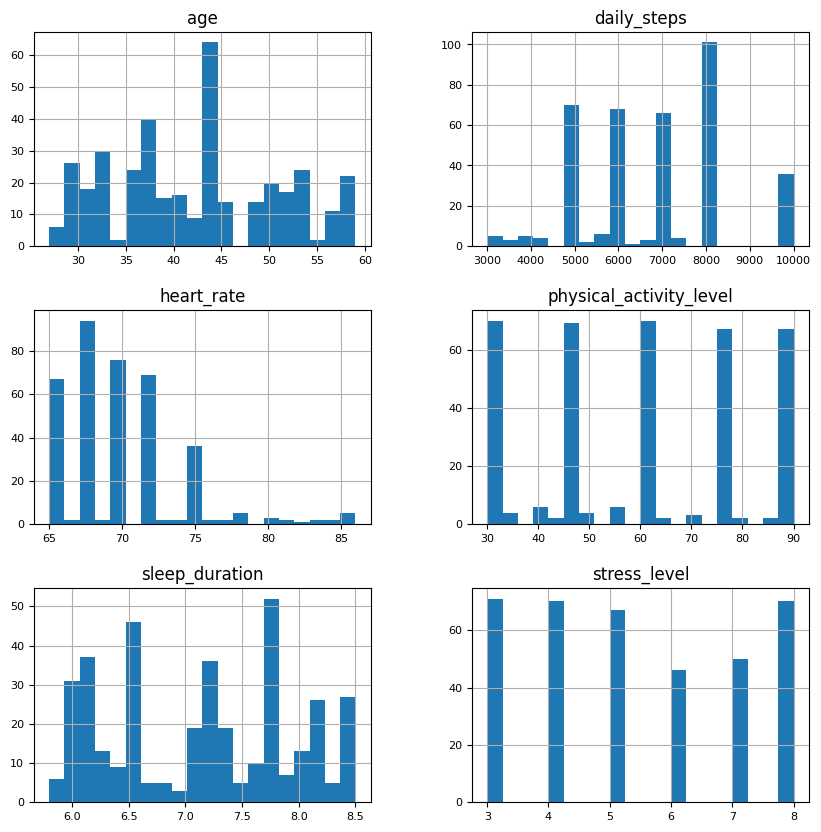

In [24]:
df_num.hist(figsize=(10,10), bins=20, xlabelsize=8, ylabelsize=8)

Lets now try the Feature to Feature relationship

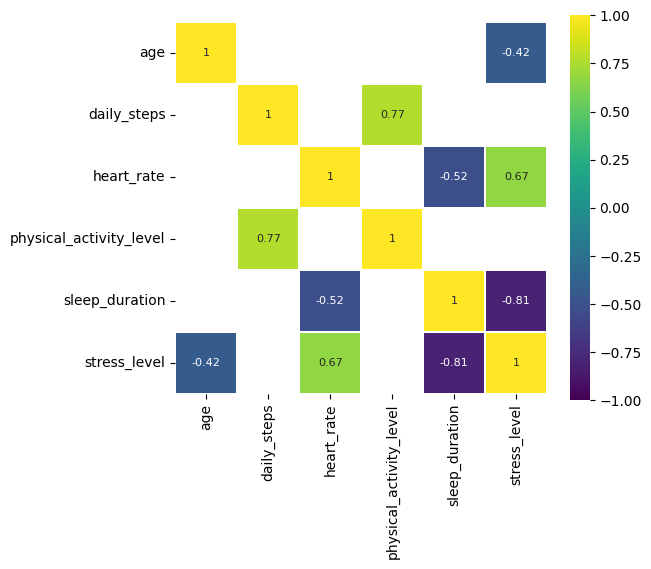

In [25]:
corr = df_num.corr()
plt.figure(figsize=(6,5))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Observations**
- `sleep_duration` and `quality_of_sleep` are positively correlated which means the longer one sleeps, the better the quality of sleep? We'll need to explore this further..
- `sleep_duration` and `quality_of_sleep` are negatively correlated with `stress_level`, which is expected
- `age` is positively correlated with systolic and diastolic, which means as we age the BP increases?
- `stress_level` and `heart_rate` are positively correlated

Lets now plot the numerical features against `quality_of_sleep` to see how they are correlated

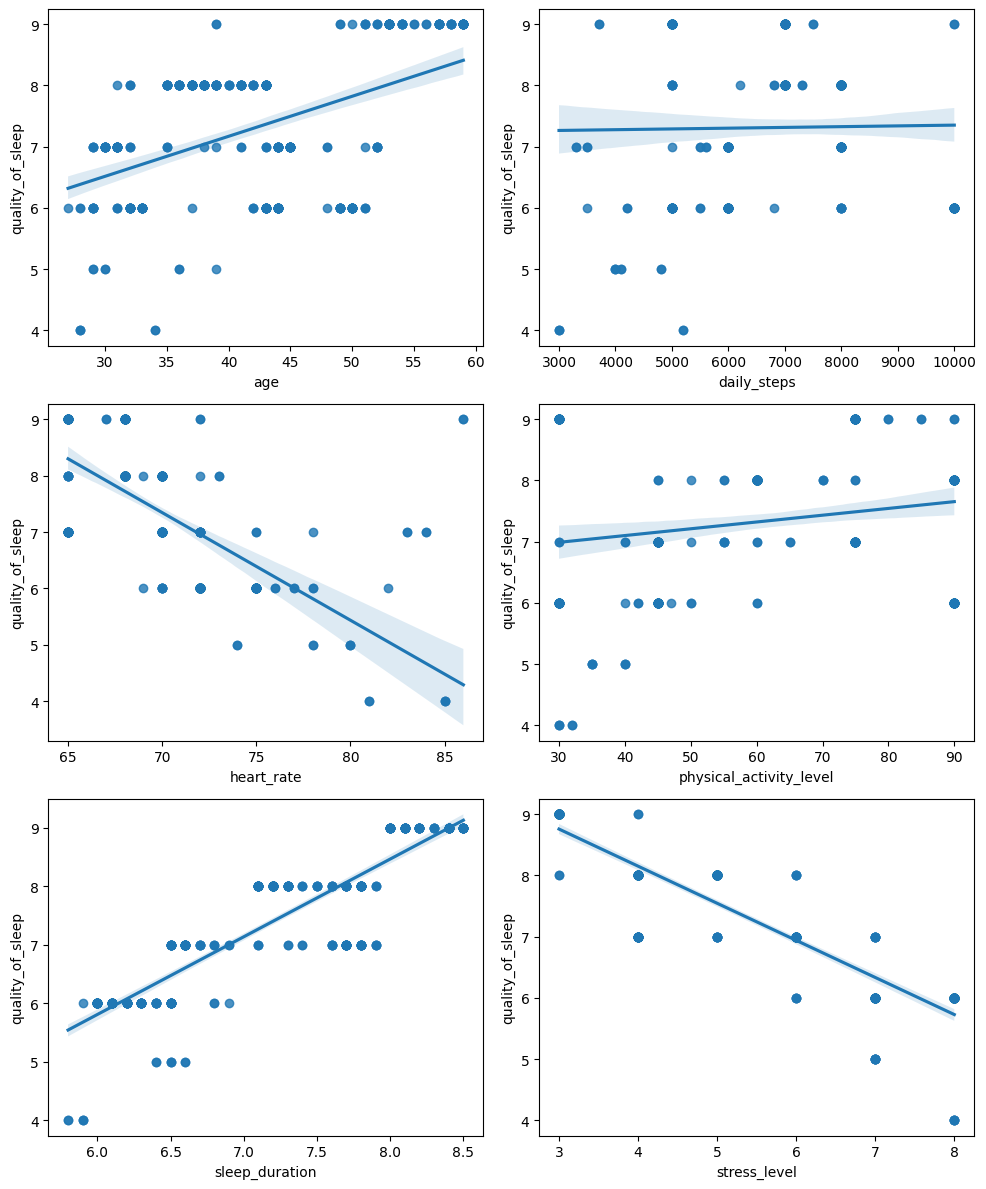

In [26]:
fig, ax = plt.subplots(round(len(numerical)/2), 2, figsize = (10,12))

for i, ax in enumerate(fig.axes):
    if i < len(numerical):
        sns.regplot(x=numerical[i], y='quality_of_sleep', data=df, ax=ax)
fig.tight_layout()

**Observations**

From the above, looks like `quality_of_sleep` is: 
- positively correlated with `age` and `sleep_duration`
- negatively correlated with `stress_level` and `heart_rate`

Now let's evaluate how the categorical variables look

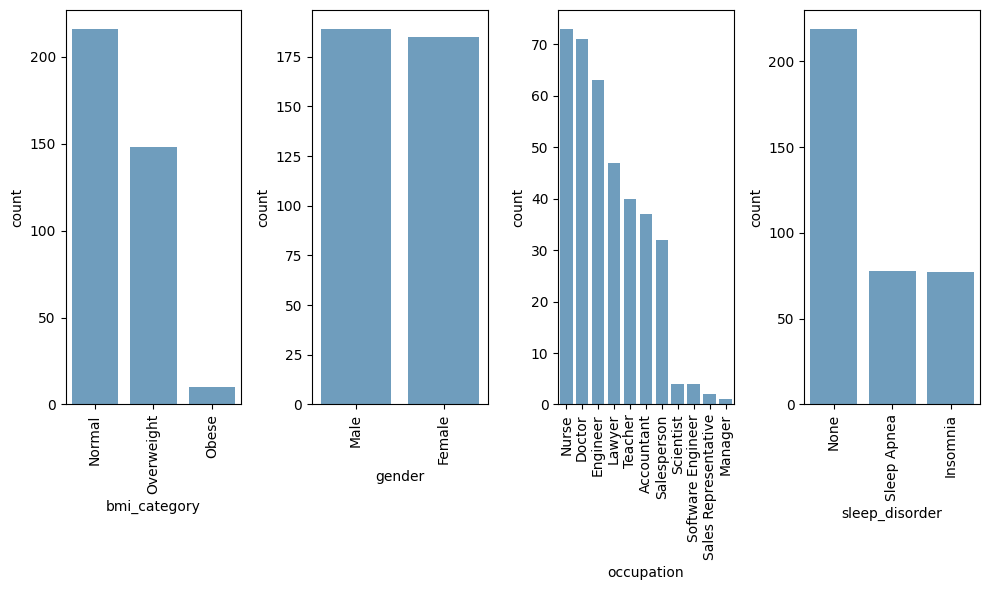

In [27]:
fig, axes = plt.subplots(round(len(categorical) / 3), len(categorical), figsize=(10,6))

for i, ax in enumerate(fig.axes):
    if i < len(categorical):
        order = df[categorical[i]].value_counts().index
        ax.tick_params(axis='x', rotation=90)
        sns.countplot(x=categorical[i], alpha=0.7, data=df[categorical], order=order, ax=ax)

fig.tight_layout()


Now lets plot the categorical variables against `quality_of_sleep`

##### Gender vs Quality of Sleep

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

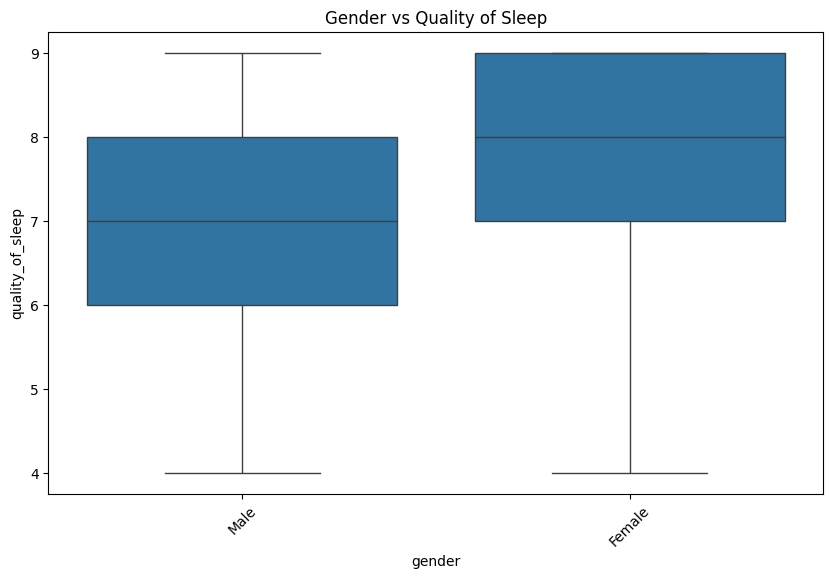

In [28]:
plt.figure(figsize = (10, 6))
order = df['gender'].value_counts().index
ax = sns.boxplot(x='gender', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Gender vs Quality of Sleep')
plt.xticks(rotation=45)

##### Occupation vs Quality of Sleep

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Nurse'),
  Text(1, 0, 'Doctor'),
  Text(2, 0, 'Engineer'),
  Text(3, 0, 'Lawyer'),
  Text(4, 0, 'Teacher'),
  Text(5, 0, 'Accountant'),
  Text(6, 0, 'Salesperson'),
  Text(7, 0, 'Scientist'),
  Text(8, 0, 'Software Engineer'),
  Text(9, 0, 'Sales Representative'),
  Text(10, 0, 'Manager')])

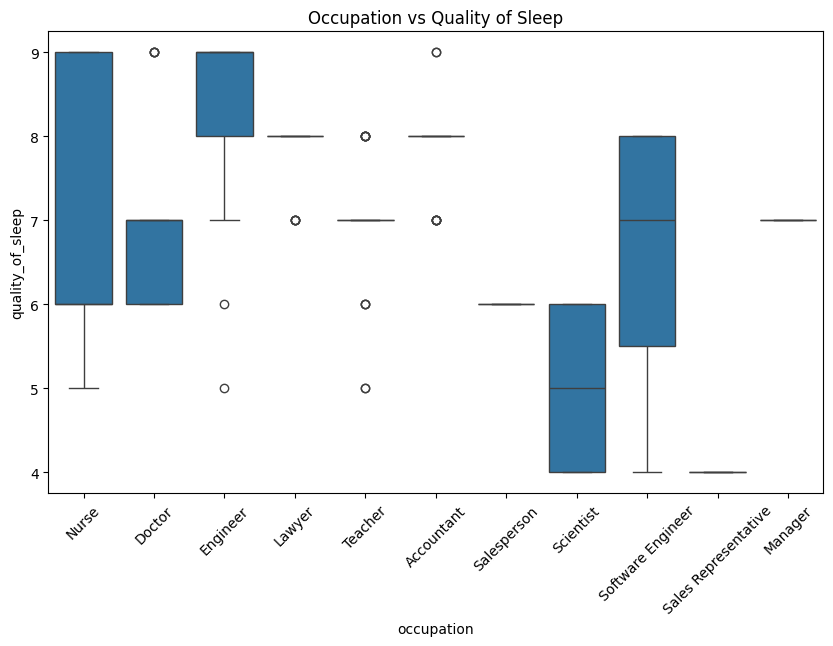

In [29]:
plt.figure(figsize = (10, 6))
order = df['occupation'].value_counts().index
ax = sns.boxplot(x='occupation', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Occupation vs Quality of Sleep')
plt.xticks(rotation=45)

##### BMI vs Quality of Sleep

([0, 1, 2],
 [Text(0, 0, 'Normal'), Text(1, 0, 'Overweight'), Text(2, 0, 'Obese')])

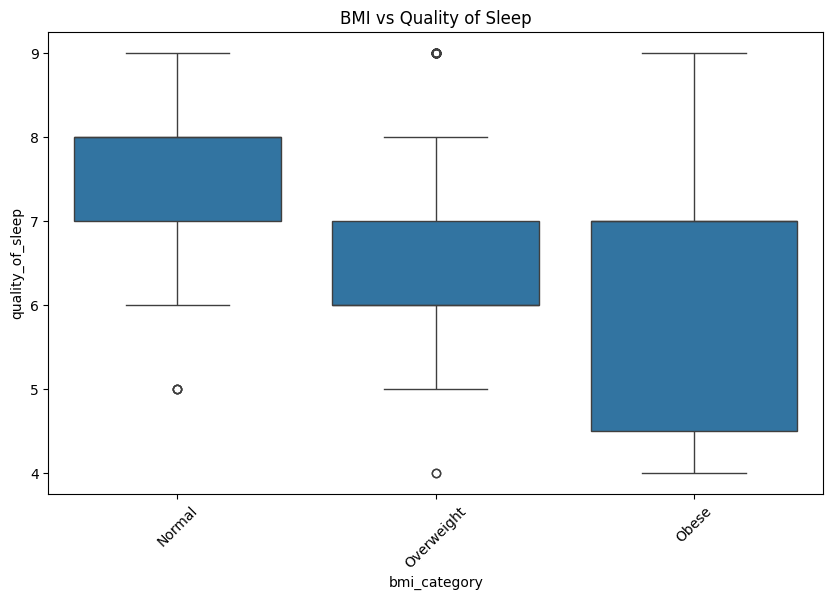

In [30]:
plt.figure(figsize = (10, 6))
order = df['bmi_category'].value_counts().index
ax = sns.boxplot(x='bmi_category', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('BMI vs Quality of Sleep')
plt.xticks(rotation=45)

([0, 1, 2],
 [Text(0, 0, 'None'), Text(1, 0, 'Sleep Apnea'), Text(2, 0, 'Insomnia')])

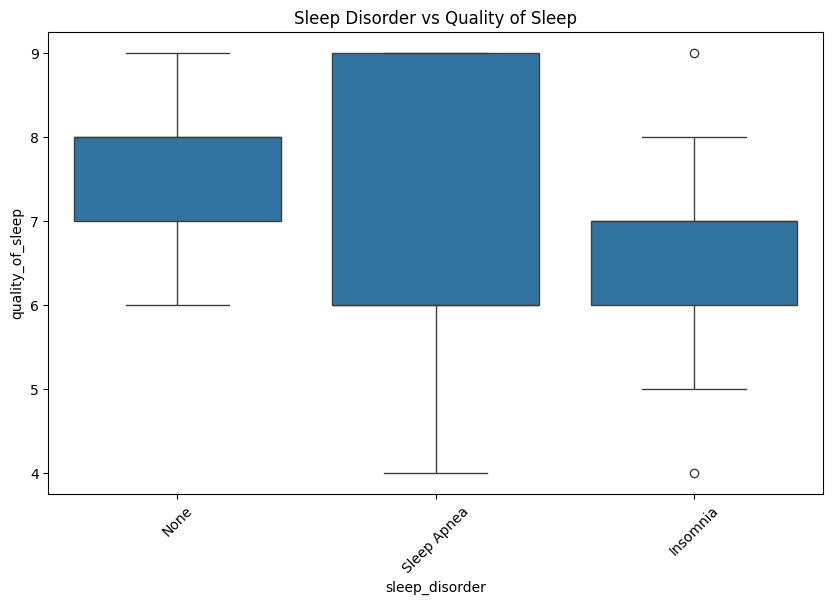

In [31]:
plt.figure(figsize = (10, 6))
order = df['sleep_disorder'].value_counts().index
ax = sns.boxplot(x='sleep_disorder', y='quality_of_sleep', data=df, order=order)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Sleep Disorder vs Quality of Sleep')
plt.xticks(rotation=45)

#### Observations from the Exploratory Data Analysis:

### 💤 Findings from Correlation Analysis with Quality of Sleep
🔹 **Positive Correlations**

- *Age*: Individuals in the 29–59 age group show a mild positive correlation with sleep quality, suggesting that middle-aged adults tend to report slightly better sleep quality compared to younger or older groups.

- *Sleep Duration*: A strong positive relationship exists — the longer one sleeps, the better the reported quality of sleep.

- *Physical Activity Level*: Shows a small positive correlation, indicating that regular physical exercise contributes to improved sleep quality.

- *Daily Steps*: Exhibits a very low correlation, suggesting that general movement throughout the day has limited direct impact on sleep quality.

🔻 **Negative Correlations**

- *Blood Pressure (Systolic & Diastolic)*: Both show weak negative correlations with sleep quality. Individuals with higher blood pressure tend to experience poorer sleep quality.

- *Heart Rate*: A negative relationship indicates that higher resting heart rates are often associated with lower sleep quality.

- *Stress Level*: Displays a strong negative correlation, confirming that increased stress levels lead to poorer sleep quality.

#### Demographic & Occupational Observations

- **Gender**:
👩 Females generally report better sleep quality compared to males.

- **Occupation**:

    - 🩺 Nurses sleep better than doctors in the medical field.

    - ⚙️ Engineers tend to have overall better sleep quality.

    - 💼 Lawyers and Accountants are among those who consistently sleep well.

    - 🍎 Teachers and Managers show average sleep quality.

    - 💻 Software Engineers exhibit average to good sleep quality.

    - 🛍️ Salespersons and Sales Representatives report the poorest sleep quality.
 

#### ⚖️ BMI and Sleep Quality

- Individuals with **normal BMI** have the **best sleep quality**.

- **Overweight** individuals show **reduced sleep quality**, and

- **Obese** individuals report the **poorest sleep quality overall**.

#### 😴 Sleep Disorders and Sleep Quality

- People with **no sleep disorder** generally sleep **reasonably well**.

- Those with **Insomnia** exhibit **low to average** sleep quality.

- Interestingly, individuals with **Sleep Apnea** show **average to very high** sleep quality — suggesting they may manage their condition effectively through treatment or lifestyle adjustments.

#### 🧠 Overall Insights

- **Sleep duration** and **stress level** are the **strongest predictors** of sleep quality.

- Maintaining a **balanced routine** — combining **adequate sleep**, **physical activity**, and **stress management** — is key to improving overall rest quality.

- Lifestyle and profession-based stressors (e.g., long working hours, irregular shifts) likely play a significant role in determining sleep health.

### Train Test Split

In [32]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [33]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [34]:
y_full_train = df_full_train.quality_of_sleep
y_train = df_train.quality_of_sleep
y_val = df_val.quality_of_sleep
y_test = df_test.quality_of_sleep

In [35]:
del df_full_train['quality_of_sleep']
del df_train['quality_of_sleep']
del df_val['quality_of_sleep']
del df_test['quality_of_sleep']

In [36]:
df_train.head()

,gender,age,occupation,sleep_duration,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Female,45,Teacher,6.6,45,4,Overweight,65,6000,None,135,90
1,Female,53,Engineer,8.5,30,3,Normal,65,5000,None,125,80
2,Male,44,Salesperson,6.3,45,7,Overweight,72,6000,Insomnia,130,85
3,Male,33,Doctor,6.0,30,8,Normal,72,5000,None,125,80
4,Male,31,Doctor,7.7,75,6,Normal,70,8000,None,120,80


In [37]:
y_train.head()

0    7
1    9
2    6
3    6
4    7
Name: quality_of_sleep, dtype: int64

#### Preprocessing pipeline
Lets build a preprocessing pipeline for data cleaning and scaling

In [38]:
# Pipeline for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Lets combine these into a Column Transformer

In [39]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical),
    ('num', numerical_transformer, numerical)
])

Let's try this for a linear regression model

In [40]:
model = LinearRegression()

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [41]:
pipe.fit(df_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
print("Model score:", pipe.score(df_val, y_val))

Model score: 0.9323069167963765


In [43]:
print("Model score:", pipe.score(df_test, y_test))

Model score: 0.9657466369375959


### Model Evaluation on Base Model (Without model tuning)
Let's add multiple models into our pipeline on base models which haven't been tuned and evaluate them to get a baseline 

In [114]:
model_eval_base = []

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso": Lasso(alpha=1),
    "Decision Tree": DecisionTreeRegressor(random_state=1),
    "Random Forest": RandomForestRegressor(random_state=1),
    "XGBoost": XGBRegressor(random_state=1, objective='reg:squarederror')
}


for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(df_train, y_train)
    score_val = pipe.score(df_val, y_val)
    print(f"{name}: R² on validation = {score_val:.3f}")
    
    score_test = pipe.score(df_test, y_test)
    print(f"{name}: R² on test= {score_test:.3f}")
    print()

    y_pred = pipe.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    model_eval_base.append((name, score_test, rmse, mae))


columns = ['Model', 'R² Baseline Model', 'RMSE Baseline Model', 'MAE Baseline Model']
df_model_eval_base = pd.DataFrame(model_eval_base, columns = columns)
df_model_eval_base

Linear Regression: R² on validation = 0.932
Linear Regression: R² on test= 0.966

Ridge Regression: R² on validation = 0.940
Ridge Regression: R² on test= 0.964

Lasso: R² on validation = 0.058
Lasso: R² on test= 0.044

Decision Tree: R² on validation = 0.943
Decision Tree: R² on test= 0.986

Random Forest: R² on validation = 0.949
Random Forest: R² on test= 0.979

XGBoost: R² on validation = 0.957
XGBoost: R² on test= 0.980



,Model,R² Baseline Model,RMSE Baseline Model,MAE Baseline Model
0,Linear Regression,0.965747,0.255093,0.153278
1,Ridge Regression,0.964277,0.260508,0.165630
2,Lasso,0.044198,1.347505,1.189035
3,Decision Tree,0.985963,0.163299,0.026667
4,Random Forest,0.979010,0.199686,0.058933
5,XGBoost,0.980189,0.193999,0.030578


### Model Tuning 
Let's tune each of these models with the **Grid search** method rather than sequential tuning because it often ignores parameter interactions. Also lets use **cross validation** to make our tuning and results more robust.

#### Linear Regression with Regularization

If model tuning were like managing a team:

- OLS hires everyone, no matter how redundant.

- Ridge keeps everyone but limits their influence.

- Lasso fires the unhelpful ones.


#### Grid search and Cross Validation for **Ridge Regression**

**Ridge Regression**: Ridge regression prevents overfitting of data by adding a penalty or a regularization term **$\alpha$**

This “shrinking” is why Ridge is also called *shrinkage regression*.

When features are correlated, Ridge spreads the importance among them instead of giving one huge weight to any single one.

In [46]:
modelval = {
    "Ridge Regression": (
        Ridge(),
        {'model__alpha':[0.01, 0.1, 10, 100]}
    )
}

In [47]:
results = []

for name, (model, params) in modelval.items():
    print(f"\n🔎 Tuning {name} ...")

    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_train, y_train)

    y_pred = grid.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best CV R²': grid.best_score_,
        'RMSE': rmse,
        'MAE': mae,
        'Validation R²': grid.score(df_val, y_val)
        })

df_results = pd.DataFrame(results)
df_results


🔎 Tuning Ridge Regression ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Model,Best Params,Best CV R²,RMSE,MAE,Validation R²
0,Ridge Regression,{'model__alpha': 10},0.945179,0.294094,0.19924,0.93483


##### Tuned Ridge Regression model

In [84]:
modelval = {
    "Ridge Regression": (
        Ridge(),
        {'model__alpha':10
        }
    )
}

#### Lasso Regression

**Lasso Regression**: Lasso (Least Absolute Shrinkage and Selection Operator) regression is a regularized version of Ordinary Least Squares (OLS) regression.

It adds a penalty term to the loss function that penalizes large coefficient values — encouraging simpler, more generalizable models.

#### Grid search and Cross Validation for **Lasso**

In [48]:
modelval = {
    "Lasso": (
        Lasso(max_iter=10000),
        {'model__alpha':[0.001, 0.01, 0.1, 10]}
    )
}

In [49]:
results = []

for name, (model, params) in modelval.items():
    print(f"\n🔎 Tuning {name} ...")

    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_train, y_train)

    y_pred = grid.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best CV R²': grid.best_score_,
        'RMSE': rmse,
        'MAE': mae,
        'Validation R²': grid.score(df_val, y_val)
        })

df_results = pd.DataFrame(results)
df_results


🔎 Tuning Lasso ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Model,Best Params,Best CV R²,RMSE,MAE,Validation R²
0,Lasso,{'model__alpha': 0.01},0.936998,0.307545,0.2171,0.936645


##### Tuned Lasso Model

In [85]:
modelval = {
    "Lasso": (
        Lasso(max_iter=10000),
        {'model__alpha': 0.01}
    )
}

#### Decision Trees

Let's tune the parameters in the Decision Tree model
- selecting max_depth
- selecting min_samples_leaf

#### Grid search and Cross Validation for **Decision Tree**

In [74]:
modelval = {
    "Decision Tree": (
        DecisionTreeRegressor(random_state=1),
        {'model__max_depth': [2, 4, 6, 8, 10, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4, 6]}
    )
}

In [75]:
results = []

for name, (model, params) in modelval.items():
    print(f"\n🔎 Tuning {name} ...")

    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_train, y_train)

    y_pred = grid.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best CV R²': grid.best_score_,
        'RMSE': rmse,
        'MAE': mae,
        'Validation R²': grid.score(df_val, y_val)
        })

df_results = pd.DataFrame(results)
df_results
print()
print('Best parameters are: ', grid.best_params_)


🔎 Tuning Decision Tree ...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


,Model,Best Params,Best CV R²,RMSE,MAE,Validation R²
0,Decision Tree,"{'model__max_depth': 6, 'model__min_samples_le...",0.967457,0.239792,0.063333,0.943302


##### Tuned Decision Tree Model

In [83]:
modelval = {
    "Decision Tree": (
        DecisionTreeRegressor(random_state=1),
        {'model__max_depth': 6,
            'model__min_samples_split': 10,
            'model__min_samples_leaf': 1
        }
    )
}

#### Random Forest Model
Let's tune the parameters in the Decision Tree model
- selecting n_estimators
- selecting max_depth
- selecting min_samples_leaf

#### Grid search and Cross Validation for **Random Forest**

In [78]:
modelval = {
    "Random Forest": (
        RandomForestRegressor(random_state=1, n_jobs=-1),
        {
            'model__n_estimators': [100, 150, 200],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4, 6]
        }
    )
}

In [79]:
results = []

for name, (model, params) in modelval.items():
    print(f"\n🔎 Tuning {name} ...")

    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_train, y_train)

    y_pred = grid.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best CV R²': grid.best_score_,
        'RMSE': rmse,
        'MAE': mae,
        'Validation R²': grid.score(df_val, y_val)
        })

df_results = pd.DataFrame(results)
df_results
print()
print('Best parameters are: ', grid.best_params_)


🔎 Tuning Random Forest ...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters are:  {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


##### Tuned Random Forest Model

In [82]:
model = { 
    "Random Forest": (
        RandomForestRegressor(random_state=1, n_jobs=-1),
        {
            'model__n_estimators': 200,
            'model__max_depth': None,
            'model__min_samples_split': 2,
            'model__min_samples_leaf': 1
        }
    )
}

### Gradient Boosting and XGBoost

#### XGBoost Parameter tuning

#### Grid search and Cross Validation for **XG Boost**

In [87]:
modelval = { 
    "XGBoost": (
        XGBRegressor(
            random_state=1,
            objective='reg:squarederror',
            enable_categorical=True,
            n_jobs=-1
        ),
        {
            'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
            'model__max_depth': [2, 4, 6],
            'model__n_estimators': [100, 150, 200],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__reg_lambda': [1, 5, 10]
        }
    )
}

In [88]:
results = []

for name, (model, params) in modelval.items():
    print(f"\n🔎 Tuning {name} ...")

    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(df_train, y_train)

    y_pred = grid.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best CV R²': grid.best_score_,
        'RMSE': rmse,
        'MAE': mae,
        'Validation R²': grid.score(df_val, y_val)
        })

df_results = pd.DataFrame(results)
df_results
print()
print('Best parameters are: ', grid.best_params_)


🔎 Tuning XGBoost ...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters are:  {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 2, 'model__n_estimators': 200, 'model__reg_lambda': 10, 'model__subsample': 0.8}


##### Tuned XGBoost Model

In [89]:
modelval = { 
    "XGBoost": (
        XGBRegressor(
            random_state=1,
            objective='reg:squarederror',
            enable_categorical=True,
            n_jobs=-1
        ),
        {
            'model__learning_rate': 0.2,
            'model__max_depth': 2,
            'model__n_estimators': 200,
            'model__subsample': 0.8,
            'model__colsample_bytree': 0.8,
            'model__reg_lambda': 10
        }
    )
}

Lets put all our trained models and evaluate it

### Model Evaluation on Tuned Models

In [115]:
models = {
    "Linear Regression": (
        LinearRegression(),
        {}  # OLS has no hyperparameters to tune
    ),
    
    "Ridge Regression": (
        Ridge(),
        {'model__alpha':10
        }
    ),
    
     "Lasso": (
        Lasso(max_iter=10000),
        {'model__alpha': 0.01}
    ),
    
    "Decision Tree": (
        DecisionTreeRegressor(random_state=1),
        {'model__max_depth': 6,
            'model__min_samples_split': 10,
            'model__min_samples_leaf': 1
        }
    ),
    
   "Random Forest": (
        RandomForestRegressor(random_state=1, n_jobs=-1),
        {
            'model__n_estimators': 200,
            'model__max_depth': None,
            'model__min_samples_split': 2,
            'model__min_samples_leaf': 1
        }
    ),
    
    "XGBoost": (
        XGBRegressor(
            random_state=1,
            objective='reg:squarederror',
            enable_categorical=True,
            n_jobs=-1
        ),
        {
            'model__learning_rate': 0.2,
            'model__max_depth': 2,
            'model__n_estimators': 200,
            'model__subsample': 0.8,
            'model__colsample_bytree': 0.8,
            'model__reg_lambda': 10
        }
    )
}

In [116]:
model_eval_tuned = []

for name, (model, params) in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    ## Apply the tuned params
    pipe.set_params(**params)

    pipe.fit(df_full_train, y_full_train)
    
    score_test = pipe.score(df_test, y_test)

    # Calculate rmse and mae
    y_pred = pipe.predict(df_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    model_eval_tuned.append((name, score_test, rmse, mae))  

columns = ['Model', 'R² Tuned Model', 'RMSE Tuned Model', 'MAE Tuned Model']
df_model_eval_tuned = pd.DataFrame(model_eval_tuned, columns = columns)
df_model_eval_tuned


,Model,R² Tuned Model,RMSE Tuned Model,MAE Tuned Model
0,Linear Regression,0.963199,0.264408,0.160910
1,Ridge Regression,0.956885,0.286193,0.192538
2,Lasso,0.954215,0.294922,0.204843
3,Decision Tree,0.967044,0.250215,0.077333
4,Random Forest,0.983258,0.178339,0.050133
5,XGBoost,0.984653,0.170750,0.054697


Now lets join the two model evaluation dataframes to see the effect of model tuning

In [117]:
model_eval = pd.merge(df_model_eval_base, df_model_eval_tuned, on='Model')
model_eval

,Model,R² Baseline Model,RMSE Baseline Model,MAE Baseline Model,R² Tuned Model,RMSE Tuned Model,MAE Tuned Model
0,Linear Regression,0.965747,0.255093,0.153278,0.963199,0.264408,0.160910
1,Ridge Regression,0.964277,0.260508,0.165630,0.956885,0.286193,0.192538
2,Lasso,0.044198,1.347505,1.189035,0.954215,0.294922,0.204843
3,Decision Tree,0.985963,0.163299,0.026667,0.967044,0.250215,0.077333
4,Random Forest,0.979010,0.199686,0.058933,0.983258,0.178339,0.050133
5,XGBoost,0.980189,0.193999,0.030578,0.984653,0.170750,0.054697


The results show that **XGBoost** model performs the best. Hence we will choose XGBoost as the **final model**.